# Dask Examples

[Dask](https://docs.dask.org/en/latest/why.html) is a Python library to scale up computations using tools like Pandas, Scikit-Learn, and Numpy to multi-core machines and distributed clusters.

Contents

1. Working with large data sets in multiple files

In [1]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [2]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## 1. Working with large data sets in multiple files

## Setup

In [3]:
%%time

# Create n large csv files (could be too big to fit all in memory)
n = 5
shape = (10000, 1000)
index_start = 0

index_end = index_start
for i in range(n):
    filepath = os.path.join(data_dir, f'datafile_{i:02d}.csv')
    index_start, index_end = index_end, index_end + shape[0]
    if not os.path.exists(filepath):
        data = (i + 1) * np.random.randn(shape[0], shape[1])
        print(f"Array {i} size in memory: {data.nbytes*1e-6:.2f} MB")
        index = pd.RangeIndex(index_start, index_end, name='Index')
        pd.DataFrame(data, index=index).to_csv(filepath)

Array 0 size in memory: 80.00 MB
Array 1 size in memory: 80.00 MB
Array 2 size in memory: 80.00 MB
Array 3 size in memory: 80.00 MB
Array 4 size in memory: 80.00 MB
CPU times: user 1min 40s, sys: 5.55 s, total: 1min 46s
Wall time: 1min 48s


## Work with data using Dask

In [4]:
from dask.distributed import Client, progress

client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:61745 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [5]:
%%time

# Read and merge all data from csv files
combined_df = dd.read_csv(os.path.join(data_dir, '*.csv')).set_index('Index')

CPU times: user 2.44 s, sys: 177 ms, total: 2.62 s
Wall time: 18.9 s


In [6]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Index,,,,,,,,,,,,,,,,,,,,,
0,-1.129139,1.284537,1.088052,-1.253457,0.490984,1.191984,-0.467351,0.080300,-0.253528,0.010188,...,1.240476,0.974962,0.167356,-1.154537,0.594116,1.649213,-0.787349,1.504162,0.178288,0.983385
1,-0.070823,0.595540,-1.540958,1.388008,0.419622,0.964640,1.615615,-2.689714,-1.055470,0.134698,...,0.465611,1.116897,-1.414046,1.362256,0.963597,-0.751364,1.238741,0.322529,0.175368,-0.127837
2,-0.232683,-0.889703,0.702711,-1.171617,-0.708523,0.093393,0.652330,-0.708180,0.911401,-0.896474,...,-0.263889,0.918541,0.298951,0.190673,-0.573595,1.175516,-0.206932,-0.066320,0.529187,0.759311
3,-1.339454,-0.245740,-1.116087,-0.720289,0.105242,-0.312194,-0.842483,0.567892,-0.425486,1.242784,...,-0.103572,-0.078953,-1.187825,-1.017503,-0.083826,0.471350,0.249307,0.533294,-1.014432,0.323634
4,2.035643,0.369033,1.092977,1.132858,-0.641834,-0.562746,-1.169171,1.642808,0.851016,-0.113057,...,-1.841875,-0.706316,-1.083549,-0.151505,0.171136,-2.509661,0.152477,0.108061,-1.569545,-1.587667


In [7]:
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Index,,,,,,,,,,,,,,,,,,,,,
49995,2.656084,-5.723478,2.992767,-1.373304,-0.809676,2.440365,-0.934688,-0.209673,1.959916,-0.731121,...,2.577678,6.887296,5.771353,-0.558412,2.139612,6.682269,-2.874145,-4.542160,-6.578731,9.212493
49996,3.575132,7.584768,-0.880743,1.277054,-1.335541,-0.842873,3.631325,-2.188766,3.539856,2.853291,...,0.687740,6.352208,9.339392,1.230229,-5.708584,1.303731,-6.171363,-1.026645,-4.487722,-6.613544
49997,-4.852932,1.664352,-1.909289,6.354981,-4.297942,-9.123930,2.663738,-0.762787,-0.378273,-7.511945,...,-3.581669,3.949568,1.075555,-12.807619,5.005144,5.194674,-4.804662,5.563043,-5.169852,3.808141
49998,0.524689,-4.540980,-8.191672,-9.465075,10.039459,1.687003,11.202740,8.066513,-2.347594,4.397023,...,-0.042540,5.069655,7.772472,-11.117755,0.759763,6.487029,11.073698,-7.354793,-1.626473,-0.957538
49999,5.122776,-2.273731,-5.900330,-6.542091,-4.175456,10.635781,0.621987,-10.042059,-1.020847,-5.882787,...,-3.411462,4.516036,9.136437,0.147661,-3.737408,4.090771,-6.298624,1.795501,-1.939175,0.140364


In [8]:
%%time

# Check none of index values are duplicated
assert np.all(combined_df.index.compute().duplicated() == False)

CPU times: user 1.21 s, sys: 88.6 ms, total: 1.3 s
Wall time: 13 s


In [9]:
%%time

# Define whatever calcs you need here
averages = combined_df.mean()
minimums = combined_df.min()
maximums = combined_df.max()

calculations = {
    'Mean': averages,
    'Min': minimums,
    'Max': maximums
}

CPU times: user 697 ms, sys: 18.4 ms, total: 716 ms
Wall time: 734 ms


In [10]:
%%time

# Execute computations
results = dd.compute(calculations)

# Note that it returns a tuple
type(results)

CPU times: user 1.29 s, sys: 120 ms, total: 1.41 s
Wall time: 17.2 s


tuple

In [11]:
pd.DataFrame(results[0])

,Mean,Min,Max
0,0.029784,-19.035872,22.677943
1,-0.007968,-19.337280,20.436544
2,-0.013063,-18.048384,19.132692
3,-0.013346,-22.819413,17.861188
4,-0.006698,-21.319032,19.434291
...,...,...,...
995,-0.004854,-20.756407,20.948565
996,0.014419,-18.532007,18.506559
997,0.003055,-20.666891,18.569508
998,0.014686,-17.462694,21.523360


In [12]:
%%time

# Go back and fetch one data record
row = combined_df.loc[25000].compute()
row

CPU times: user 87.8 ms, sys: 12.1 ms, total: 99.9 ms
Wall time: 1.67 s


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Index,,,,,,,,,,,,,,,,,,,,,
25000,5.372379,-2.355472,-2.967035,-3.760164,2.816584,-1.255135,2.785642,-2.294785,1.412207,-2.83168,...,5.352513,-4.699892,1.211378,-1.420659,2.07996,0.790668,0.327662,-4.92435,0.364929,-0.704221


## Visualize the computation graph

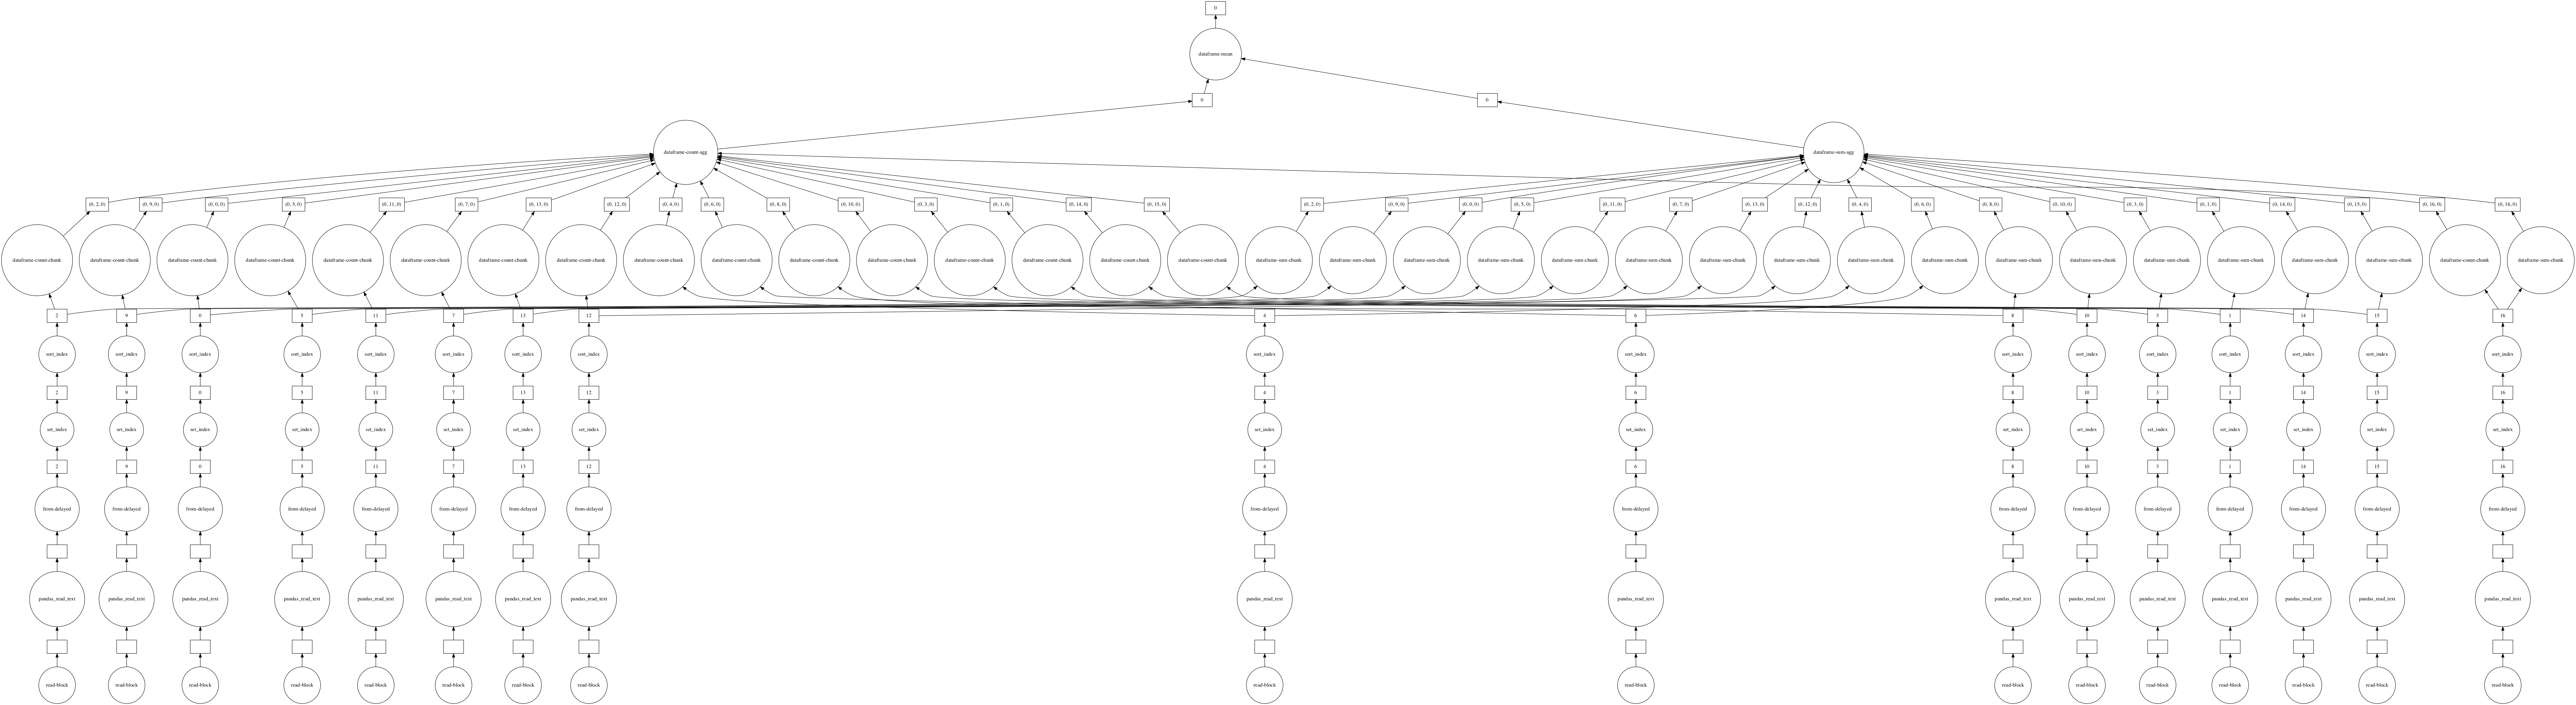

In [13]:
averages.visualize(filename='compgraph.pdf')
averages.visualize()

In [15]:
# Clean up
client.close()

del combined_df, calculations, results

## Speed comparison with Pandas

In [16]:
%%time

indexes = []
filenames = []
df_sums = []
df_counts = []
df_mins = []
df_maxes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, filename)).set_index('Index')
        indexes.append(df.index)
        filenames.append(filename)
        df_sums.append(df.sum())
        df_counts.append(df.count())
        df_mins.append(df.min())
        df_maxes.append(df.max())
del df

index_values = np.hstack(indexes)

calculations = {
    'Mean': np.stack(df_sums).sum(axis=0) / np.stack(df_counts).sum(axis=0),
    'Min': np.stack(df_mins).min(axis=0),
    'Max': np.stack(df_maxes).max(axis=0)
}

pd.DataFrame(calculations)

CPU times: user 18.1 s, sys: 1.37 s, total: 19.4 s
Wall time: 19.5 s


,Mean,Min,Max
0,0.029784,-19.035872,22.677943
1,-0.007968,-19.337280,20.436544
2,-0.013063,-18.048384,19.132692
3,-0.013346,-22.819413,17.861188
4,-0.006698,-21.319032,19.434291
...,...,...,...
995,-0.004854,-20.756407,20.948565
996,0.014419,-18.532007,18.506559
997,0.003055,-20.666891,18.569508
998,0.014686,-17.462694,21.523360


In [17]:
%%time

# Fetch one data record
i = 25000

for file, index in enumerate(indexes):
    if i in index:
        break
else:
    raise ValueError('Index value not found in data')

df = pd.read_csv(os.path.join(data_dir, filenames[file])).set_index('Index')
row = df.loc[i]
row

CPU times: user 2.73 s, sys: 210 ms, total: 2.94 s
Wall time: 2.94 s


0      5.372379
1     -2.355472
2     -2.967035
3     -3.760164
4      2.816584
         ...   
995    0.790668
996    0.327662
997   -4.924350
998    0.364929
999   -0.704221
Name: 25000, Length: 1000, dtype: float64

## Delete csv files

In [ ]:
for filename in os.listdir(data_dir):
    os.remove(os.path.join(data_dir, filename))
